In [70]:
pip install scikit-surprise

In [71]:
!pip install pandas scikit-surprise flask streamlit pyngrok

In [72]:
!ngrok config add-authtoken 2pEpDRaCsRFQ2Yu8CwcxInREjF9_xsexVsE31E3SL1G2j9iD

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

In [74]:
data = pd.read_csv('assignment.csv')
data.head()

,User ID,Product ID,Product Category,Purchase Date,Ratings
0,1,101,Electronics,10-01-2024,5
1,1,102,Books,12-01-2024,4
2,1,103,Clothing,15-01-2024,3
3,2,101,Electronics,11-01-2024,4
4,2,104,Books,13-01-2024,5


In [75]:
# Check basic information about the dataset
print("\nDataset Info:")
data.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   User ID           15 non-null     int64 
 1   Product ID        15 non-null     int64 
 2   Product Category  15 non-null     object
 3   Purchase Date     15 non-null     object
 4   Ratings           15 non-null     int64 
dtypes: int64(3), object(2)
memory usage: 728.0+ bytes


In [76]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
User ID             0
Product ID          0
Product Category    0
Purchase Date       0
Ratings             0
dtype: int64


In [77]:
# Descriptive statistics
print("\nDescriptive Statistics:")
print(data.describe())


Descriptive Statistics:
        User ID  Product ID    Ratings
count  15.00000   15.000000  15.000000
mean    3.00000  104.400000   4.066667
std     1.46385    2.995234   0.798809
min     1.00000  101.000000   3.000000
25%     2.00000  102.000000   3.500000
50%     3.00000  104.000000   4.000000
75%     4.00000  106.500000   5.000000
max     5.00000  110.000000   5.000000


In [78]:
# Analyze unique users and products
print("\nUnique Users and Products:")
print(f"Number of unique users: {data['User ID'].nunique()}")
print(f"Number of unique products: {data['Product ID'].nunique()}")


Unique Users and Products:
Number of unique users: 5
Number of unique products: 10


In [79]:
# Analyze product popularity
product_popularity = data['Product ID'].value_counts()
print("\nTop 5 Most Purchased Products:")
print(product_popularity.head())


Top 5 Most Purchased Products:
Product ID
101    3
102    2
103    2
104    2
105    1
Name: count, dtype: int64


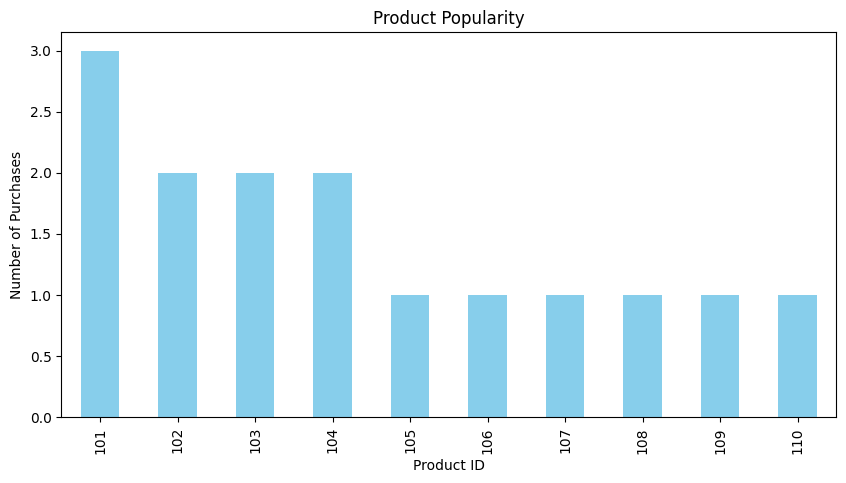

In [80]:
# Plot: Product Popularity
plt.figure(figsize=(10, 5))
product_popularity.plot(kind='bar', color='skyblue')
plt.title("Product Popularity")
plt.xlabel("Product ID")
plt.ylabel("Number of Purchases")
plt.show()

In [81]:
# Analyze category distribution
category_distribution = data['Product Category'].value_counts()
print("\nProduct Categories Distribution:")
print(category_distribution)


Product Categories Distribution:
Product Category
Books          5
Clothing       4
Electronics    3
Furniture      3
Name: count, dtype: int64


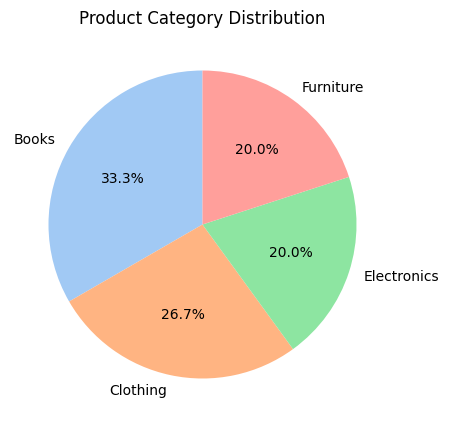

In [82]:
# Plot: Category Distribution
plt.figure(figsize=(8, 5))
category_distribution.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title("Product Category Distribution")
plt.ylabel("")  # Hide the y-axis label for a cleaner look
plt.show()

In [83]:
# Analyze ratings
print("\nRatings Distribution:")
print(data['Ratings'].value_counts())


Ratings Distribution:
Ratings
4    6
5    5
3    4
Name: count, dtype: int64


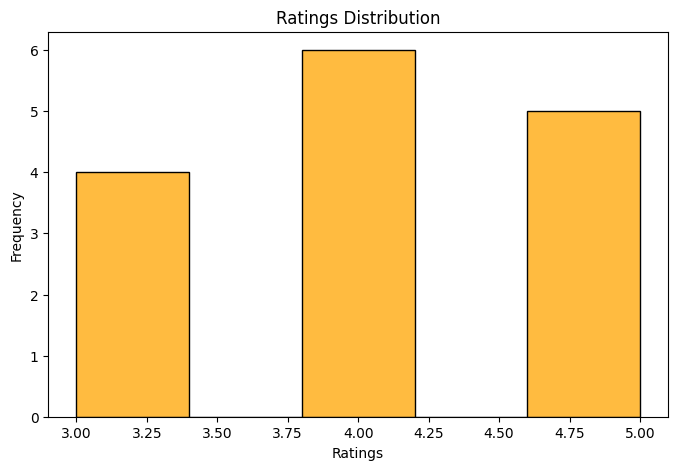

In [84]:
# Plot: Ratings Distribution
plt.figure(figsize=(8, 5))
sns.histplot(data['Ratings'], bins=5, kde=False, color="orange")
plt.title("Ratings Distribution")
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.show()

In [85]:
# Prepare the data for the Surprise library
reader = Reader(rating_scale=(1, 5))  # Define rating scale
surprise_data = Dataset.load_from_df(data[['User ID', 'Product ID', 'Ratings']], reader)

# Split data into training and testing sets
trainset, testset = train_test_split(surprise_data, test_size=0.2, random_state=42)

# Build the collaborative filtering model
model = SVD()  # Singular Value Decomposition (SVD)

# Train the model
model.fit(trainset)

# Test the model
predictions = model.test(testset)

# Evaluate the model using RMSE
rmse = accuracy.rmse(predictions)
print(f"Model RMSE: {rmse}")

RMSE: 0.7310
Model RMSE: 0.7309675423281246


In [87]:
# Function to get product recommendations for a user
def get_recommendations(user_id, top_n=5):
    # Get a list of all product IDs
    all_products = data['Product ID'].unique()

    # Get products already rated by the user
    rated_products = data[data['User ID'] == user_id]['Product ID']

    # Find unrated products
    unrated_products = [product for product in all_products if product not in rated_products.values]

    # Predict ratings for unrated products
    recommendations = []
    for product_id in unrated_products:
        pred = model.predict(user_id, product_id)
        recommendations.append((product_id, pred.est))

    # Sort by predicted rating
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n]

# Example: Get top 5 recommendations for user ID 1
user_id = 1
recommended_products = get_recommendations(user_id, top_n=5)
print(f"Top 5 Recommendations for User {user_id}:")
for product_id, rating in recommended_products:
    print(f"Product ID: {product_id}, Predicted Rating: {rating:.2f}")

Top 5 Recommendations for User 1:
Product ID: 110, Predicted Rating: 4.35
Product ID: 106, Predicted Rating: 4.14
Product ID: 107, Predicted Rating: 4.12
Product ID: 109, Predicted Rating: 4.11
Product ID: 104, Predicted Rating: 4.08


In [88]:
from surprise.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    "n_factors": [50, 100, 150],
    "n_epochs": [10, 20, 30],
    "lr_all": [0.002, 0.005, 0.01],
    "reg_all": [0.02, 0.1, 0.2]
}

# Perform grid search
grid_search = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=3)
grid_search.fit(surprise_data)

# Best parameters and RMSE
best_params = grid_search.best_params["rmse"]
print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {grid_search.best_score['rmse']}")

# Train the final model with best parameters
best_model = SVD(**best_params)
best_model.fit(trainset)

# Test the model
predictions = best_model.test(testset)
accuracy.rmse(predictions)

Best Parameters: {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.2}
Best RMSE: 0.7787544892929535
RMSE: 0.7972


0.7971524930490874

In [89]:
def precision_recall_at_k(predictions, k=5, threshold=3.5):
    """Calculate Precision and Recall at K."""
    # Map predictions to each user
    user_est_true = {}
    for uid, iid, true_r, est, _ in predictions:
        if uid not in user_est_true:
            user_est_true[uid] = []
        user_est_true[uid].append((est, true_r))

    precisions = []
    recalls = []

    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Take the top K items
        n_relevant = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_recommend = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Calculate precision and recall
        precisions.append(n_recommend / k if k != 0 else 0)
        recalls.append(n_recommend / n_relevant if n_relevant != 0 else 0)

    # Average precision and recall across users
    precision = sum(precisions) / len(precisions) if precisions else 0
    recall = sum(recalls) / len(recalls) if recalls else 0

    return precision, recall

In [90]:
# Calculate Precision and Recall at K
precision, recall = precision_recall_at_k(predictions, k=5, threshold=3.5)
print(f"Precision@5: {precision:.2f}")
print(f"Recall@5: {recall:.2f}")

# Calculate F1-Score
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f"F1-Score: {f1_score:.2f}")

Precision@5: 0.20
Recall@5: 0.67
F1-Score: 0.31


In [91]:
from flask import Flask, request, jsonify
from pyngrok import ngrok

# Set up the Flask app
app = Flask(__name__)

@app.route('/recommend', methods=['GET'])
def recommend():
    user_id = int(request.args.get('user_id'))
    top_n = int(request.args.get('top_n', 5))
    try:
        recommendations = get_recommendations(user_id, top_n)
        return jsonify({"user_id": user_id, "recommendations": recommendations})
    except Exception as e:
        return jsonify({"error": str(e)})

# Run the Flask app with ngrok
if __name__ == "__main__":
    # Expose the app via ngrok
    public_url = ngrok.connect(5000).public_url
    print(f"Public URL: {public_url}")
    app.run(port=5000)

Public URL: https://18ec-34-170-113-249.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [23/Nov/2024 07:04:23] "GET / HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [23/Nov/2024 07:04:24] "GET /favicon.ico HTTP/1.1" 404 -


In [95]:
import streamlit as st
from pyngrok import ngrok

# Streamlit app
code = """
import streamlit as st
import pandas as pd
from surprise import SVD, Dataset, Reader

data = pd.read_csv('assignment.csv')

reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(data[['User ID', 'Product ID', 'Ratings']], reader)
trainset = surprise_data.build_full_trainset()
model = SVD()
model.fit(trainset)

def get_recommendations(user_id, top_n=5):
    all_products = data['Product ID'].unique()
    user_rated_products = data[data['User ID'] == user_id]['Product ID']
    unrated_products = [p for p in all_products if p not in user_rated_products.values]

    recommendations = []
    for product_id in unrated_products:
        prediction = model.predict(user_id, product_id).est
        recommendations.append((product_id, prediction))

    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)
    return [product for product, _ in recommendations[:top_n]]

st.title("Product Recommendation System")

user_id = st.number_input("Enter User ID", min_value=1, step=1)
top_n = st.number_input("Number of Recommendations", min_value=1, max_value=10, step=1, value=5)

if st.button("Get Recommendations"):
    recommendations = get_recommendations(user_id, top_n)
    st.write(f"Recommendations: {recommendations}")
"""

# Save the code to app.py
with open('app.py', 'w') as f:
    f.write(code)

# Start ngrok for Streamlit
public_url = ngrok.connect(8501).public_url
print(f"Public URL: {public_url}")

# Run Streamlit app
!streamlit run app.py

Public URL: https://f5f5-34-170-113-249.ngrok-free.app



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.170.113.249:8501

  Stopping...
  Stopping...


In [1]:
pip freeze > requirements.txt